In [2]:
import pandas_datareader.data as web
import pandas as pd
from datetime import date
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import numpy as np
import math
import time
from yahoofinancials import YahooFinancials
from scipy import stats
from statistics import mean
from scipy.stats import percentileofscore
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
from decimal import Decimal
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
from plotly.subplots import make_subplots
import pickle
import yfinance as yf
from matplotlib.pyplot import figure
import robin_stocks as rs
import mplfinance as mpf
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display

# Getting sector and market cap from robin:
1. Using yahoo_fin.stock_info to get the list of all tickers in SP500
2. Using robin_stocks to match each ticker with its sector

In [4]:
sp_list = si.tickers_sp500()
sp_list = [x for x in sp_list if x != 'CXO']
ll = []
for tick in sp_list:
    sector = rs.stocks.get_fundamentals(tick, info='sector')
    market_cap = rs.stocks.get_fundamentals(tick, info='market_cap')
    ll.append([tick, sector, market_cap])
col = ['Ticker', 'Sector', 'Market Cap']    
df_sector = pd.DataFrame(ll, columns=col)
df_sector['Sector'] = df_sector['Sector'].str[0]
df_sector['Market Cap'] = df_sector['Market Cap'].str[0]
df_sector['Market Cap'] = df_sector['Market Cap'].astype(float)
df_sector = df_sector.set_index('Ticker')
df_sector['Weight'] = 'N/A'

# Assigning weights to each company in its sector

In [5]:
for i in df_sector['Sector'].unique().tolist():
    total_sector_cap = df_sector[df_sector['Sector'] == i]['Market Cap'].sum()
    for ii in df_sector[df_sector['Sector'] == i].index.tolist():
        df_sector.loc[ii, 'Weight'] = df_sector.loc[ii, 'Market Cap'] / total_sector_cap        
df_sector.head()

,Sector,Market Cap,Weight
Ticker,,,
A,Health Technology,3.737358e+10,0.0106975
AAL,Transportation,1.084332e+10,0.0171407
AAP,Retail Trade,1.047765e+10,0.00320516
AAPL,Electronic Technology,2.294865e+12,0.457726
ABBV,Health Technology,1.851299e+11,0.0529899


# Loading prices for each ticker in S&P500:
for the last 5 years using robin_stocks

In [6]:
sp_list = si.tickers_sp500()
#CXO is not a valid member of SP500, getting rid of it:
sp_list = [x for x in sp_list if x != 'CXO']
l = []
for tick in sp_list:
    data = rs.stocks.get_stock_historicals(tick, interval="day", span="5year")
    df_data = pd.DataFrame(data)
    df_data = df_data.set_index('begins_at')
    df_data = df_data[['close_price', 'volume']]
    df_data = df_data.add_suffix(f'_{tick}')
    l.append(df_data)
final = pd.concat(l, axis=1)   
final.index = pd.to_datetime(final.index)
new_format = "%Y-%m-%d"
final.index = final.index.strftime(new_format)
final = final.dropna()
final = final.sort_index()

In [7]:
final.head()

,close_price_A,volume_A,close_price_AAL,volume_AAL,close_price_AAP,volume_AAP,close_price_AAPL,volume_AAPL,close_price_ABBV,volume_ABBV,...,close_price_YUM,volume_YUM,close_price_ZBH,volume_ZBH,close_price_ZBRA,volume_ZBRA,close_price_ZION,volume_ZION,close_price_ZTS,volume_ZTS
2016-01-27,37.050000,1479446.0,39.690000,10185956.0,151.520000,988265.0,23.355000,533478696.0,57.110000,9077707.0,...,48.479301,4175141.0,101.640000,1970843.0,57.270000,937749.0,21.780000,6364095.0,43.150000,3242486.0
2016-01-28,36.110000,3479452.0,38.140000,17112266.0,148.560000,1002058.0,23.522500,222715300.0,55.850000,10521072.0,...,49.184835,5856075.0,97.550000,2306972.0,55.700000,452677.0,22.150000,5320236.0,42.840000,5660560.0
2016-01-29,37.650000,2959863.0,38.990000,20957476.0,152.050000,1255571.0,24.335000,257666016.0,54.900000,17768683.0,...,50.553991,6189491.0,99.260000,2242571.0,60.400000,678349.0,22.680000,4663810.0,43.050000,7032635.0
2016-02-01,37.690000,2666567.0,39.380000,12023520.0,154.890000,862905.0,24.107500,163774164.0,54.390000,11693273.0,...,51.063932,7004082.0,99.030000,1561584.0,60.020000,725798.0,22.500000,3114083.0,42.960000,4703045.0
2016-02-02,37.070000,1742325.0,37.030000,12401401.0,151.860000,713105.0,23.620000,149428860.0,53.950000,7918304.0,...,50.519064,14813765.0,98.040000,1204823.0,57.930000,875717.0,21.540000,4338012.0,41.720000,3441505.0


### We'll keep only price data and change column names to tickers

In [8]:
price = final.filter(like='close_price_')
ii = sp_list
price = price.rename(columns={f'close_price_{i}': i for i in ii})
price[ii] = price[ii].astype(float)
#returns = price.pct_change()
#returns
price.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-01-20,128.11,16.17,165.18,132.03,112.62,103.79,347.87,112.89,261.67,469.73,...,138.00,49.53,58.68,21.05,104.00,109.41,163.46,406.55,48.30,163.36
2021-01-21,127.00,15.83,166.68,136.87,111.26,104.91,348.56,112.95,257.94,472.02,...,141.16,48.11,57.64,21.35,103.14,107.88,162.96,406.20,47.39,164.46
2021-01-22,126.33,15.82,163.76,139.07,110.86,107.76,347.90,112.84,254.77,472.44,...,142.94,47.43,57.23,21.07,102.60,107.09,161.01,408.84,48.12,163.33
2021-01-25,125.48,15.43,159.66,142.92,110.50,106.87,348.32,114.72,252.04,473.44,...,145.14,46.90,57.01,20.75,101.00,105.26,159.31,402.63,47.21,161.34
2021-01-26,123.92,15.53,157.63,143.16,108.80,108.84,340.89,114.73,252.99,476.28,...,144.39,45.87,57.16,21.07,99.23,106.34,158.22,395.16,46.05,159.71


# Sector prices
In order to get prices for each sector we multiply each ticker price by its weight and sum the result for each ticker in sector list

In [10]:
#Multiplying ticker price by its weight:
price_weighted = price.copy()
all_sectors = df_sector['Sector'].tolist()
for sect in set(all_sectors):
    in_sector = df_sector[df_sector['Sector'] == sect].index.tolist()
    for i in in_sector:
        price_weighted[i] = price_weighted[i] * df_sector.loc[i, 'Weight']

#Getting sum of each weighted price to come to sector price
price_sector = pd.DataFrame()
for sect in set(all_sectors):
    in_sector = df_sector[df_sector['Sector'] == sect].index.tolist()
    price_sector[sect] = (price_weighted[[i for i in in_sector]]).sum(axis=1)

In [11]:
price_sector.head()

,Health Services,Finance,Health Technology,Consumer Non-Durables,Communications,Consumer Durables,Transportation,Process Industries,Electronic Technology,Producer Manufacturing,Commercial Services,Distribution Services,Technology Services,Retail Trade,Energy Minerals,Industrial Services,Utilities,Consumer Services,Non-Energy Minerals
2016-01-27,108.209939,78.481150,91.203028,70.622889,41.002135,62.718128,69.235503,99.800813,43.620538,66.869986,68.929622,87.273538,278.642047,343.434687,68.954736,36.953813,48.658836,128.842875,37.590057
2016-01-28,106.655523,78.307551,88.874061,71.760970,41.060506,62.876591,69.443522,99.787180,43.768764,67.691441,68.509140,86.809873,290.600852,369.897409,70.986112,37.828257,49.455262,129.594540,37.416591
2016-01-29,109.909989,81.123592,90.725192,73.114277,41.994931,63.544397,71.279431,101.655111,45.300823,69.725269,70.600634,88.665946,296.450737,346.856473,72.278343,38.880284,50.434857,131.611879,39.346731
2016-02-01,110.640039,80.750727,90.740518,73.205168,42.456823,64.244999,71.786036,101.846038,45.311436,69.405748,70.223747,88.829447,299.849652,341.117446,71.110808,38.579620,50.860887,133.677870,39.213505
2016-02-02,108.942550,78.936245,89.352125,72.511282,41.742548,61.673940,70.528791,100.491988,44.101816,68.094104,68.252205,86.869889,302.672431,329.094022,68.794497,37.719441,51.018379,131.281286,38.568592


# Defining Constant Proportion Portfolio Return (CPPI)

${V}_{risky} = m*(V - F)$ <br>
where
${V}_{risky}$ is the value of assets in the risky portfolio
$V$ is the starting value of the total portfolio
$F$ is the asset level below which the total portfolio should not fall and
$m \geq 1$ is the multiplier (how risky you wanna be) <br>
<br>
We are going to use STIP ETF as "safe" asset where $V - {V}_{risky}$ will be invested

In [12]:
safe = rs.stocks.get_stock_historicals('STIP', interval="day", span="5year")
df_safe = pd.DataFrame(safe)
df_safe = df_safe.set_index('begins_at')
df_safe = df_safe[['close_price', 'volume']]
df_safe.index = pd.to_datetime(df_safe.index)
df_safe['close_price'] = df_safe['close_price'].astype(float)
df_safe['Return'] = df_safe['close_price'].pct_change()
df_safe = df_safe.dropna()

In [13]:
df_safe.head()

,close_price,volume,Return
begins_at,,,
2016-01-28 00:00:00+00:00,99.3100,27680,0.000806
2016-01-29 00:00:00+00:00,99.4128,15395,0.001035
2016-02-01 00:00:00+00:00,99.2700,42411,-0.001436
2016-02-02 00:00:00+00:00,99.3300,16082,0.000604
2016-02-03 00:00:00+00:00,99.3600,69341,0.000302


## CPPI model:
Input DataFrame of asset returns (risky_r), Series of a safe return and specify the drawdown level

In [14]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/350 # fast way to set all values to a number
    #else:
        #o = safe_r
        #safe_r = pd.DataFrame().reindex_like(risky_r)
        #safe_r.loc[:,:] = o.values[:,None]
    
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result, safe_r

## Showing the results
Looking at Transportation and Energy Minerals starting from 2020 <br>
Plotting the results

In [24]:
price_sector['2020':][['Transportation', 'Energy Minerals']].pct_change().dropna()

,Transportation,Energy Minerals
2020-01-03,-0.005970,-0.006310
2020-01-06,-0.005426,0.006204
2020-01-07,0.000382,-0.004473
2020-01-08,0.008990,-0.016967
2020-01-09,0.001882,0.005867
...,...,...
2021-01-20,0.014755,0.006378
2021-01-21,-0.018938,-0.033738
2021-01-22,-0.006007,-0.004309
2021-01-25,0.004285,-0.008775


In [28]:
r = price_sector[['Transportation', 'Energy Minerals']].pct_change().dropna()

In [29]:
s = df_safe['Return']

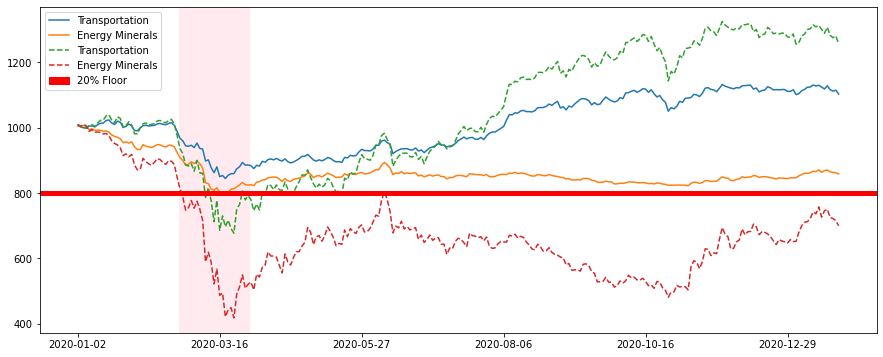

In [124]:
btr = run_cppi(r['2020-01-01':], s['2020-01-01':], m=3, drawdown=0.20)
ax = btr[0]["Wealth"].plot(figsize=(15,6))
btr[0]["Risky Wealth"].plot(ax=ax, style="--")
ax.axvspan(35.5, 60.5, facecolor ='pink', alpha = 0.3)
a = plt.axhline(1000*0.8, c='r', linewidth=5)
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch( color='red', label='20% Floor')

# handles is a list, so append manual patch
handles.append(patch) 
plt.legend(handles=handles, loc='upper left', fontsize=10)

<AxesSubplot:title={'center':'Allocations to the risky portfolios from the period of 03-01-2020 to 03-16-2020'}>

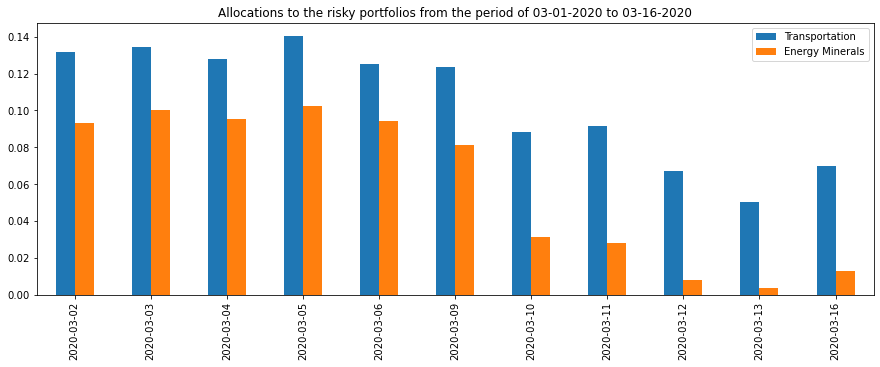

In [133]:
btr[0]['Risk Budget']['2020-03-01':'2020-03-16'].plot(kind='bar', figsize=(15,5), title='Allocations to the risky portfolios from the period of 03-01-2020 to 03-16-2020')

In [126]:
btr[0]['Wealth']['Energy Minerals'].nsmallest(9).sort_index(ascending = False)

2020-03-23    813.641089
2020-03-20    812.172853
2020-03-19    803.212647
2020-03-18    794.910070
2020-03-17    799.842294
2020-03-16    802.308406
2020-03-13    816.379778
2020-03-12    808.769645
2020-03-11    812.246072
Name: Energy Minerals, dtype: float64

In [128]:
btr[0]['Risky Wealth']['Energy Minerals'].nsmallest(9).sort_index(ascending = False)

2020-10-29    496.890451
2020-10-28    481.336282
2020-03-24    490.978871
2020-03-23    417.721662
2020-03-20    449.056707
2020-03-19    443.523402
2020-03-18    421.658407
2020-03-17    494.241566
2020-03-16    487.053763
Name: Energy Minerals, dtype: float64

In [127]:
btr[0]['safe_r']['2020-03-10':'2020-03-21']

begins_at
2020-03-10 00:00:00+00:00   -0.008736
2020-03-11 00:00:00+00:00   -0.017226
2020-03-12 00:00:00+00:00   -0.001647
2020-03-13 00:00:00+00:00    0.008539
2020-03-16 00:00:00+00:00   -0.012196
2020-03-17 00:00:00+00:00   -0.003074
2020-03-18 00:00:00+00:00   -0.006166
2020-03-19 00:00:00+00:00    0.010445
2020-03-20 00:00:00+00:00    0.011155
Name: Return, dtype: float64